In [1]:
from pprint import pprint
from datetime import datetime
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

from utils import *

In [2]:
fp = Statistics.compute_failure_proportion_statistics()
fl = Statistics.compute_failure_length_statistics()
fc = Statistics.compute_failure_count_statistics()
scores = dict(FP=fp, FL=fl, FC=fc)

fp
fl
fc


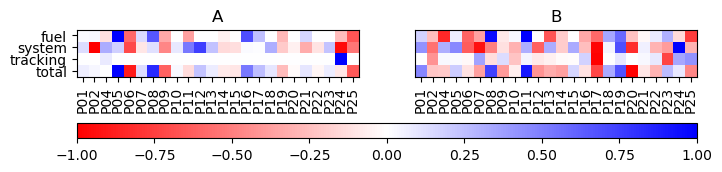

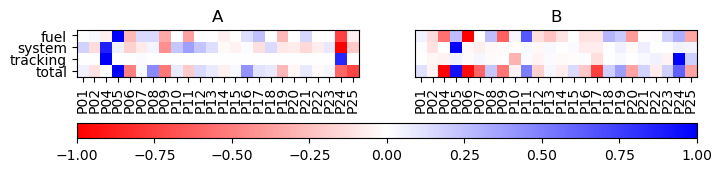

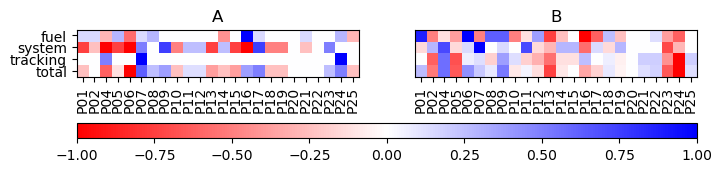

In [27]:
# PLOT DIFFERENCE PERFORMANCE METRICS
def plot_performance(df, rnd=False, vmin=-1, vmax=1):
    grouped = df.select_dtypes(include=['float','integer']).groupby(df['experiment'])
    data = {name:group.values for name,group in grouped}
    use_vs = not (vmin is None and vmax is None)
    
    def _plot(k1, k2, ax, showbar=False):
        # icua should have a LOWER score. If dif is positive then the agents helped.
        dif = (data[k2].astype(np.float64) - data[k1].astype(np.float64)) 
    
        dif /= np.abs(dif).max(axis=0)
    
        indx = (np.where(dif < 0, -1, np.where(dif > 0, 1, 0))).astype(int) if rnd else dif    
        
        
        cmap = matplotlib.colormaps.get_cmap("bwr").reversed()
        _vmin, _vmax = vmin, vmax
        if not use_vs:
            _vmax, _vmin = dif.max(), dif.min()
            _v = max(abs(_vmin), _vmax)
            _vmin, _vmax = -_v, _v
        return ax.imshow(indx.T, cmap=cmap, vmin=_vmin, vmax=_vmax)

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
    axA, axB = axes.ravel()
    
    imA = _plot('icuaA', 'icuA', axA)
    imB = _plot('icuaB', 'icuB', axB, showbar=True)
    axA.set_yticks(np.arange(len(df.columns[2:])), df.columns[2:])
    pars = df['participant'].unique()
    axA.set_xticks(np.arange(len(pars)), pars, rotation=90)
    axA.set_title("A")
    
    axB.tick_params(axis='both', which='both',top=False,left=False,right=False)
    axB.set_yticks([],[])
    axB.set_xticks(np.arange(len(pars)), pars, rotation=90)
    plt.colorbar(imA, ax=[axB, axA], aspect = 40, location="bottom") ##Common colobar for ax1 and ax2; aspect used to set colorbar thickness/width
    axB.set_title("B")
    return fig
       


print("fp")
fig = plot_performance(fp, vmin=-1, vmax=1)
#fig.suptitle("FP",y=0.6,x=0.5)
plt.savefig("./results/fp-agents.png", bbox_inches="tight")

print("fl")
fig = plot_performance(fl, vmin=-1, vmax=1)
#fig.suptitle("Mean Failure Length", y=0.6,x=0.5)
plt.savefig("./results/fl-agents.png", bbox_inches="tight")
print("fc")
fig = plot_performance(fc, vmin=-1, vmax=1)
plt.savefig("./results/fc-agents.png", bbox_inches="tight")
#fig.suptitle("Failure Count", y=0.6,x=0.5)



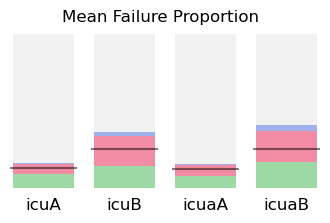

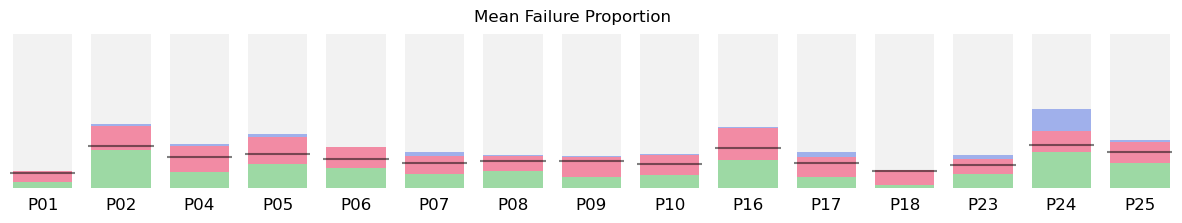

In [9]:
def plot_mean(df, groupby, total_color = "black"):
    data = df.select_dtypes(include='float').groupby(groupby)
    fig, axes = plt.subplots(ncols=len(data), nrows=1, figsize=(len(data),2))
    fig.suptitle("Mean Failure Proportion", y=1)
    _axes = iter(axes.ravel())
    for (indx, mu), (_, sigma) in zip(data.mean().iterrows(), data.std().iterrows()):
        ax = next(_axes)
        ax.axis('off')
        prop_scale = 3
        ax.set_ylim(0,prop_scale) 
        for i, (k, v) in enumerate(zip(mu.keys()[:-1], mu.values[:-1])):
            ax.bar(0, v, bottom=sum(mu.values[:i]), width=1, align='center', alpha=alpha, color=ALL_WINDOW_PROPERTIES[k]['color'])
        ax.bar(0, prop_scale-sum(mu.values[:-1]), bottom=sum(mu.values[:-1]), width=1, align='center', alpha=0.05,color='black')
        ax.axhline(y=mu.values[-1], color=total_color, alpha=alpha)
        ax.set_title(indx,y=-0.2)

def plot_differences(df, groupby, alpha=1):
    grouped = df.select_dtypes(include='float').groupby(groupby)
    data = {name:group.values for name,group in grouped}
    # if this is negative, the agents did bad.
    difA = data['icuA'] - data['icuaA'] # icua should have a LOWER failure proportion.
    difB = data['icuB'] - data['icuaB'] # icua should have a LOWER failure proportion.

    fig, axes = plt.subplots(ncols=len(difA), nrows=2, figsize=(len(difA)/2,4), sharey=True)
    #fig.suptitle("Differences")
    ylima = max(abs(np.min(difA)), abs(np.max(difA)))
    ylimb = max(abs(np.min(difB)), abs(np.max(difB)))
    for (A,B,(axa, axb)) in zip(difA, difB, axes.T):
        axa.set_xticklabels([]),  axb.set_xticklabels([])
        axa.tick_params(axis='both', which='both', bottom=False, top=False,left=False,right=False)
        axb.tick_params(axis='both', which='both', bottom=False, top=False,left=False,right=False)
        prop_scale = 3
        axa.set_ylim(-ylima, ylima), axb.set_ylim(-ylimb, ylimb)
        
        #axa.set_ylim(0,prop_scale), axb.set_ylim(0,prop_scale) 
        for i,(k, a, b) in enumerate(zip(df.select_dtypes(include='float').columns[:-1], A[:-1],B[:-1])):
            axa.axhline(y=a, color=ALL_WINDOW_PROPERTIES[k]['color'], alpha=alpha)
            axb.axhline(y=b, color=ALL_WINDOW_PROPERTIES[k]['color'], alpha=alpha)
    axes[0,0].tick_params(left=True)
    axes[1,0].tick_params(left=True)
    axes[0,axes.shape[1]//2].text(-1.4,-0.62,"Differences A (Easy)")
    axes[1,axes.shape[1]//2].text(-1.4,-0.62,"Differences B (Hard)")
    for ax, par in zip(axes[0], df['participant'].unique()):
        ax.set_title(par, size="medium")  
        
#plot_differences(df, df['experiment'])

# MEAN OF FAILURE PROPORTIONS
plot_mean(fp, fp['experiment'])
plot_mean(fp, fp['participant'])




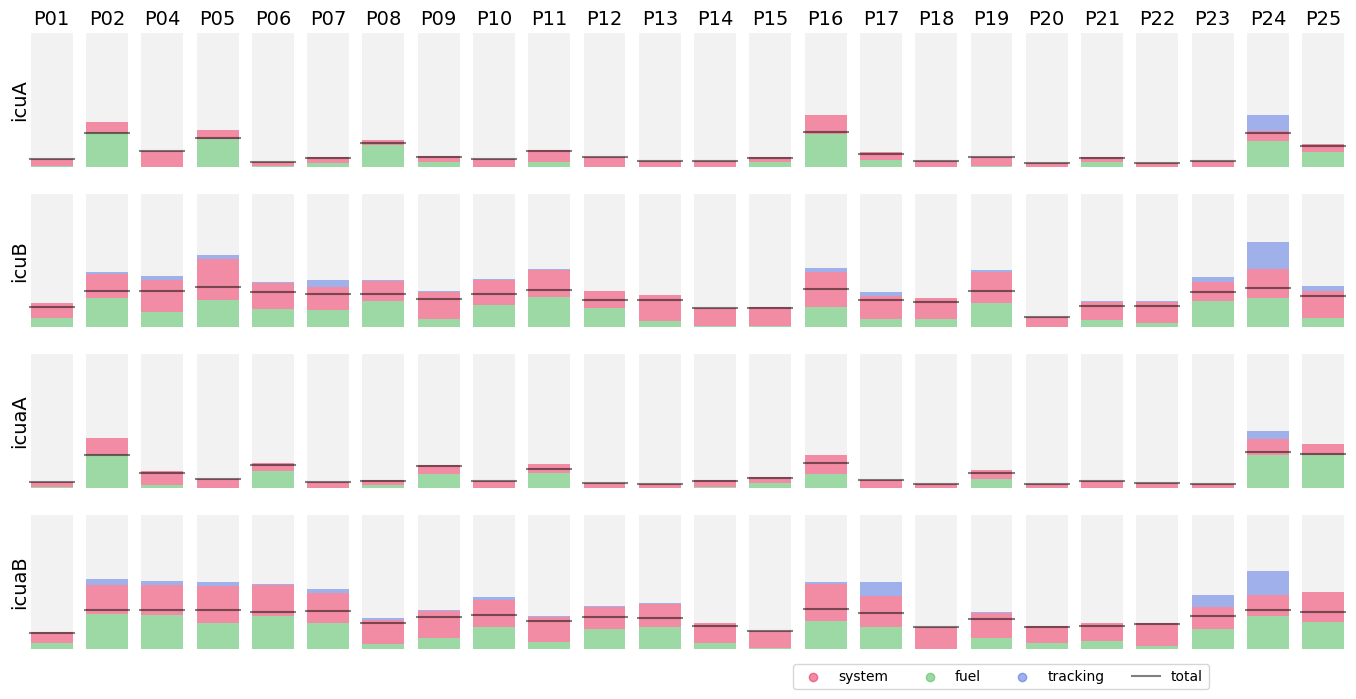

In [13]:
score = fp
exp = score['experiment'].unique()
par = score['participant'].unique()
fig, axes = plt.subplots(ncols=len(par), nrows=len(exp), figsize=(17,8))
prop_scale = 3 # one for fuel,syste & tracking (assuming scores are normalised where 1 is the maximum possible)
alpha = 0.5
for (i, srow), ax in zip(score.iterrows(), axes.T.ravel()):
    #print(srow.to_numpy())
    ax.axis('off'), ax.set_ylim(0, prop_scale)
    current_bottom = 0
    for task in ['fuel', 'system', 'tracking']:
        ax.bar(0, srow[task], bottom=current_bottom, width=1, align='center', alpha=alpha, color=ALL_WINDOW_PROPERTIES[task]['color'])
        current_bottom += srow[task]
    ax.bar(0, prop_scale, bottom=current_bottom, width=1, align='center', alpha=0.05, color='black')
    ax.axhline(y=srow['total'], color='black', alpha=alpha)
    #print(srow)

for p, ax in zip(par, axes[0]):
    ax.set_title(p, fontsize=14)
for e, ax in zip(exp, axes[:,0]):
    ax.text(-0.2, 0.5, e, transform=ax.transAxes, rotation=90, va='center', ha='center', fontsize=14)
    
for k,v in ALL_WINDOW_PROPERTIES.items():
    plt.gca().scatter([],[], label=k, color=v['color'], alpha=alpha) # for legend purposes
plt.gca().plot([],[], label='total', color='black', alpha=alpha) 
plt.legend(loc=(-11,-0.3), ncols=len(ALL_WINDOW_PROPERTIES)+1) 
plt.show()



